We are setting information at the normal curve $N(0.2,1)$.

In [1]:
#from PIL import Image
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages')
import os
import numpy as np
import importlib
from numpy import linalg
import helperfuns 
from helperfuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
import sympy as sp
from sympy import *
from sympy.solvers import solve
np.set_printoptions(precision=3, suppress = True)
import pandas as pd
import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator
# for formatting tick labels
from matplotlib.ticker import FormatStrFormatter

Declare symbols used

In [2]:
from sympy.abc import lamda
from sympy.abc import beta, eta, gamma
from sympy.abc import theta, xi
#Dw, Du1, Du2, Dbu, Dp1, Dp2 = sp.symbols('\Delta_w, \Delta_{u_1}, \Delta_{u_2}, \Delta_{u_3}, \Delta_{p_1}, \Delta_{p_2}', real = True)
#Dx1, Dx2, Dbx, Dy1, Dy2, Dby, Dr1, Dr2 = sp.symbols('\Delta_{x_1}, \Delta_{x_2}, \Delta_{x_3}, \Delta_{y_1}, \Delta_{y_2}, \Delta_{y_3}, \Delta_{r_1}, \Delta_{r_2}', real = True)
#U1,U2,bU,X1,X2,bX,Y1,Y2,bY,A1,A2 = sp.symbols('U_1,U_2,U_3,X_1,X_2,X_3,Y_1,Y_2,Y_3,A_1,A_2', real = True)
p, u,u1,u2,bu,x1,x2,bx,y1,y2,by,r1,r2, W = sp.symbols('p, u,\hat{u_1},\hat{u_2},\bar{u},x_1,x_2,x_3,y_1,y_2,y_3,\hat{r_1},\hat{r_2}, W', real = True)
ui,uj,ri,rj = sp.symbols('u_i, u_j, r_i, r_j')
K,D,pc, pw = sp.symbols('K,D,\pi_C, \pi_W', real = True)
ds, dD, dk, dpc, dpw = sp.symbols('\delta_s, \delta_D, \delta_K, \delta_{\pi_C}, \delta_{\pi_W}', real = True)
l = sp.symbols('\lambda', real = True)
fs = sp.symbols('f(s)', real = True)


In [3]:
phi = p*(2*p -1)*(1-p)
Wu1 = u*(1 + r1)*(K*(u1 + D*phi.subs([(p,u1)])) + pc)
Wu2 = u*(1 + r2)*(K*(u2 + D*phi.subs([(p,u2)])) + pc)
Wbu = u*(K*(1 - u1 - u2 - D*phi.subs([(p,u1)])-D*phi.subs([(p,u2)])) + pw)
Wval = Wu1 + Wu2 + Wbu

# Local Stability

In [4]:
Du = Du1 + Du2 + Dbu
Dx = Dx1 + Dx2 + Dbx
Dy = Dy1 + Dy2 + Dby
from sympy.abc import phi
phi1 = sp.symbols('\phi_1')
phi2 = sp.symbols('\phi_2')
theta1 = sp.symbols('\theta_1')
theta2 = sp.symbols('\theta_2')



Learnperturb_u1 = (r1 + Dr1)*(K*(u1 + Dp1 + D*(phi1 + Dp1*theta1)) + pc)
Learnperturb_u2 = Learnperturb_u1.subs([(r1,r2),(Dr1,Dr2),(u1,u2),(Dp1,Dp2), (phi1,phi2), (theta1,theta2)])
Learnperturb_x1 = Learnperturb_u1.subs([(K,K+dk),(pc,pc+dpc),(Dr1,0),(Dp1,0)])
Learnperturb_x2 = Learnperturb_x1.subs([(r1,r2),(u1,u2),(phi1,phi2)])
Learnperturb_y1 = Learnperturb_u1.subs([(D,D+dD),(Dr1,0),(Dp1,0)])
Learnperturb_y2 = Learnperturb_y1.subs([(r1,r2),(u1,u2), (phi1,phi2)])


WplusdW = (1+Du)*(1 + pc + Learnperturb_u1 + Learnperturb_u2) + Dx*(1+pc+ dpc + Learnperturb_x1 + Learnperturb_x2) + Dy*(1+pc+Learnperturb_y1 + Learnperturb_y2)
WplusdW = WplusdW.subs([(Dp1,Du1+Dx1 + Dy1),(Dp2, Du2+Dx2+Dy2)])

NameError: name 'Du1' is not defined

In [5]:
WplusdW = expand(WplusdW)
p = Poly(WplusdW,Du1,Du2,Dbu,Dx1,Dx2,Dbx,Dy1,Dy2,Dby,Dr1,Dr2)

NameError: name 'WplusdW' is not defined

# J star

In [4]:
def Make_Jstar(hw,hu1,hu2,hr1,hr2,K,D):
    theta_fun1 = 6*hu1*(1-hu1) -1
    theta_fun2 = 6*hu2*(1-hu2) -1
    U1 = K*(1 + D*theta_fun1)
    U2 = K*(1+D*theta_fun2)
    A1 = hw*hu1/(1+hr1)
    A2 = hw*hu2/(1 + hr2)
    
    row1 = [U1*(1 + hr1 - hu1*hr1), -hu1*hr2*U2, A1*(1-hu1), -hu1*A2]
    row1 = [item/hw for item in row1]
    row2 = [-hu2*hr1*U1, U2*(1 + hr2-hu2*hr2), -hu2*A1, A2*(1-hu2)]
    row2 = [item/hw for item in row2]
    row3 = [-beta*hr1/(1+hr1),0,1/(1+hr1),0]
    row4 = [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]
    Jstar = Matrix([row1,row2,row3,row4])
    return(Jstar)

def Make_Jstar_np(hw,hu1,hu2,hr1,hr2,K,D,beta):
    theta_fun1 = 6*hu1*(1-hu1) -1
    theta_fun2 = 6*hu2*(1-hu2) -1
    U1 = K*(1 + D*theta_fun1)
    U2 = K*(1+D*theta_fun2)
    A1 = hw*hu1/(1+hr1)
    A2 = hw*hu2/(1 + hr2)
    
    row1 = [U1*(1 + hr1 - hu1*hr1), -hu1*hr2*U2, A1*(1-hu1), -hu1*A2]
    row1 = [item/hw for item in row1]
    row2 = [-hu2*hr1*U1, U2*(1 + hr2-hu2*hr2), -hu2*A1, A2*(1-hu2)]
    row2 = [item/hw for item in row2]
    row3 = [-beta*hr1/(1+hr1),0,1/(1+hr1),0]
    row4 = [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]
    Jstar = np.array([row1,row2,row3,row4])
    return(Jstar)

def get_u1_K0(pc,beta):
    if pc==0:
        hu1 = 0
        return(hu1)
    if beta == 0:
        hu1 = 2*pc/(1+3*pc)
        return(hu1)
    if (pc>0) & (beta > 0):
        hu1 = ((1 + 3*pc + pc*beta) - np.sqrt((1 + 3*pc + pc*beta)**2 -16*pc**2*beta))/(4*pc*beta)
    return(hu1)
def get_leading_Jstar_eval_K0D0(pc,beta):
    hu1 = get_u1_K0(pc,beta)
    hr1 = 1 - beta*hu1
    hw = 1 + pc *2*pc*hr1
    Jstar = Make_Jstar_np(hw,hu1,hu1,hr1,hr1,0,0,beta)
    evals = linalg.eigvals(Jstar)
    evals_mag = abs(evals)
    lead_eval = max(evals_mag)
    return(lead_eval)

# K = 0, small delta_d approximation

In [11]:
# test internal stability

hu1 = u1
hu2 = hu1
hr1 = r1
hr2 = hr1
Kval = 0
Dval = 0
hw = 1 + pc *2*pc*hr1
Jstar = Make_Jstar(hw,hu1,hu2,hr1,hr2,Kval,Dval)

In [39]:
display(Jstar)
charpoly = Jstar.charpoly(lamda).as_expr()
solns = solve(charpoly,lamda)
for sol in solns:
    display(sol)

Matrix([
[                              0,                               0, \hat{u_1}*(1 - \hat{u_1})/(\hat{r_1} + 1),             -\hat{u_1}**2/(\hat{r_1} + 1)],
[                              0,                               0,             -\hat{u_1}**2/(\hat{r_1} + 1), \hat{u_1}*(1 - \hat{u_1})/(\hat{r_1} + 1)],
[-\hat{r_1}*beta/(\hat{r_1} + 1),                               0,                         1/(\hat{r_1} + 1),                                         0],
[                              0, -\hat{r_1}*beta/(\hat{r_1} + 1),                                         0,                         1/(\hat{r_1} + 1)]])

-(sqrt(-4*\hat{r_1}*\hat{u_1}*beta + 1) - 1)/(2*\hat{r_1} + 2)

(sqrt(-4*\hat{r_1}*\hat{u_1}*beta + 1) + 1)/(2*\hat{r_1} + 2)

-(sqrt(8*\hat{r_1}*\hat{u_1}**2*beta - 4*\hat{r_1}*\hat{u_1}*beta + 1) - 1)/(2*\hat{r_1} + 2)

(sqrt(8*\hat{r_1}*\hat{u_1}**2*beta - 4*\hat{r_1}*\hat{u_1}*beta + 1) + 1)/(2*\hat{r_1} + 2)

In [19]:
u1_k0 = ((1 + 3*pc + pc*beta) - sqrt((1 + 3*pc + pc*beta)**2 -16*pc**2*beta))/(4*pc*beta)
solns = [sol.subs([(r1,1-beta*u1)]) for sol in solns]
solns = [sol.subs([(u1,u1_k0)]) for sol in solns]

In [40]:
charpoly = charpoly.subs([(r1,1-beta*u1)])
charpoly = factor(charpoly)

In [45]:
charpoly

(\hat{u_1}*beta*lamda + \hat{u_1}*beta - 2*lamda)*(\hat{u_1}*beta*lamda - \hat{u_1}*beta - 2*lamda + 1)*(2*\hat{u_1}**3*beta**2 + \hat{u_1}**2*beta**2*lamda**2 - \hat{u_1}**2*beta**2 - 2*\hat{u_1}**2*beta - 4*\hat{u_1}*beta*lamda**2 + \hat{u_1}*beta*lamda + \hat{u_1}*beta + 4*lamda**2 - 2*lamda)/(\hat{u_1}*beta - 2)**4

In [53]:
charpoly_third = 2*u1**3*beta**2 + u1**2*beta**2*lamda**2 - u1**2*beta**2 - 2*u1**2*beta 
charpoly_third = charpoly_third - 4*u1*beta*lamda**2+u1*beta*lamda + u1*beta + 4*lamda**2 - 2*lamda
charpoly_third.collect(lamda)
charpoly_third.subs([(lamda,1),(u1,1/2)])

0.25*beta**2 - 1.5*beta + 2

In [52]:
charpoly_third.subs([(lamda,1)]).collect(u1)

2*\hat{u_1}**3*beta**2 - 2*\hat{u_1}**2*beta - 2*\hat{u_1}*beta + 2

In [50]:
factor(2*u1**3*beta**2 - u1**2*beta**2 - 2*u1**2*beta+u1*beta)

\hat{u_1}*beta*(2*\hat{u_1} - 1)*(\hat{u_1}*beta - 1)

In [16]:
# plot the evals
pcvec = np.arange(0.0,1,0.02)
betavec = np.arange(0.0,1,0.02)
PC,BETA = np.meshgrid(pcvec,betavec)
pcflat = np.ndarray.flatten(PC)
betaflat = np.ndarray.flatten(BETA)

finalshape = np.shape(PC)
eigvec = [get_leading_Jstar_eval_K0D0(pc,beta) for pc,beta in zip(pcflat,betaflat)]
eigmat = np.reshape(eigvec,finalshape)

In [17]:
eigmat_is_stable = eigmat < 1

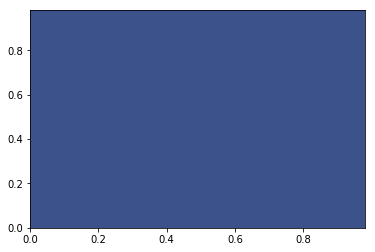

In [18]:
plt.contourf(PC,BETA,eigmat_is_stable)

In [66]:
u1_K0 = ((1+3*pc+pc*beta)-sqrt((1+3*pc+pc*beta)**2-16*pc**2*beta))/(4*pc*beta)


In [65]:
lower_lim_Kinvades = (1-sqrt(1-beta))/(2*beta)

left = simplify(u1_K0 - lower_lim_Kinvades)

newLeft.subs([(pc,0.1),(beta,0.5)])

NameError: name 'u1_K0' is not defined

In [10]:
pcvec = np.arange(0.01,1,0.0001)
betavec = np.arange(0.01,1,0.0001)
PC, BETA = np.array(np.meshgrid(pcvec,betavec), dtype = float)
def SignCsK0D0(beta,u1):
    determinesSign = -1 + 4*(1-beta*u1)*u1
    to_return = np.array(determinesSign>0, dtype = int)
    return(to_return)
def fun_u1_K0(pc,beta):
    u1hat = ((1+3*pc+pc*beta)-np.sqrt((1+3*pc+pc*beta)**2-16*pc**2*beta))/(4*pc*beta)
    return(u1hat)

U1 = fun_u1_K0(PC,BETA)
Xinvades = SignCsK0D0(BETA,U1)


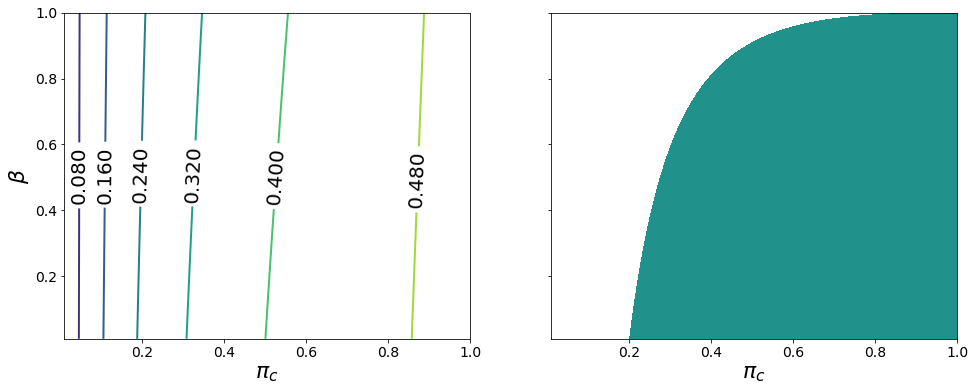

In [36]:
 #Define a class that forces representation of float to have only one decimal point if there's a trailing z

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,6))

CS = ax1.contour(PC,BETA,U1, linewidths = 2)
#ax1.clabel(CS,CS.levels,fontsize=12, rightside_up = True, inline_spacing=3)


#fix the labels so they don't go off the axis

xmin,xmax,ymin,ymax = ax1.axis()
# middle of the figure:
mid = ((xmin+xmax)/2, (ymin + ymax)/2)

# find new position sof labels that are cose to center
label_pos = []
for line in CS.collections:
    for path in line.get_paths():
        vert = path.vertices
        
        #find closest point
        dist = np.linalg.norm(vert-mid,ord=2,axis=1)
        min_ind = np.argmin(dist)
        label_pos.append(vert[min_ind,:])
        
#draw labels
ax1.clabel(CS,inline=True,inline_spacing=3,colors = 'k', fontsize = 20, rightside_up=True, manual = label_pos)
CF = ax2.contourf(PC,BETA,Xinvades, levels = [0.5,1.5])

ax1.set_xlabel('$\pi_c$', fontsize = 22)
ax2.set_xlabel('$\pi_c$', fontsize = 22)
ax1.set_ylabel('$\\beta$', fontsize = 22)
#both plots have teh same axes so don't need labels of right plot's y-axis
ax2.axes.yaxis.set_ticklabels([])
ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('Figures/xinvadesK0D0.png')

# Case K > 0, D = 0

## Case $u_1 = u_2$

In [51]:
Cubic = u1**3*(-2*beta*K)+u1**2*(2*K + K*beta - 3*beta*pc) + u1*(1+3*pc -2*K + beta*pc) - 2*pc
solns = solve(Cubic,u1)
solns[0]
# need to solve this with fsolve

def CubicD0(u1, params):
    [beta,K,pc] = params
    Cubic = u1**3*(-2*beta*K)+u1**2*(2*K + K*beta - 3*beta*pc) + u1*(1+3*pc -2*K + beta*pc) - 2*pc
    return(Cubic)



-(-3*(2*K - \pi_C*beta - 3*\pi_C - 1)/(2*K*beta) + (-K*beta - 2*K + 3*\pi_C*beta)**2/(4*K**2*beta**2))/(3*(sqrt(-4*(-3*(2*K - \pi_C*beta - 3*\pi_C - 1)/(2*K*beta) + (-K*beta - 2*K + 3*\pi_C*beta)**2/(4*K**2*beta**2))**3 + (27*\pi_C/(K*beta) - 9*(-K*beta - 2*K + 3*\pi_C*beta)*(2*K - \pi_C*beta - 3*\pi_C - 1)/(4*K**2*beta**2) + (-K*beta - 2*K + 3*\pi_C*beta)**3/(4*K**3*beta**3))**2)/2 + 27*\pi_C/(2*K*beta) - 9*(-K*beta - 2*K + 3*\pi_C*beta)*(2*K - \pi_C*beta - 3*\pi_C - 1)/(8*K**2*beta**2) + (-K*beta - 2*K + 3*\pi_C*beta)**3/(8*K**3*beta**3))**(1/3)) - (sqrt(-4*(-3*(2*K - \pi_C*beta - 3*\pi_C - 1)/(2*K*beta) + (-K*beta - 2*K + 3*\pi_C*beta)**2/(4*K**2*beta**2))**3 + (27*\pi_C/(K*beta) - 9*(-K*beta - 2*K + 3*\pi_C*beta)*(2*K - \pi_C*beta - 3*\pi_C - 1)/(4*K**2*beta**2) + (-K*beta - 2*K + 3*\pi_C*beta)**3/(4*K**3*beta**3))**2)/2 + 27*\pi_C/(2*K*beta) - 9*(-K*beta - 2*K + 3*\pi_C*beta)*(2*K - \pi_C*beta - 3*\pi_C - 1)/(8*K**2*beta**2) + (-K*beta - 2*K + 3*\pi_C*beta)**3/(8*K**3*beta**3))**(

## Subcase: $u_i = 0$, $u_1 \neq u_2$

In [5]:
hr1 = Rational(1,1)
hr2 = Rational(1,1) - beta*u2
hu1 = 0
hu2 = u2
hw = Rational(1,1) + K*hr2*hu2
Jstar = Make_Jstar(hw,hu1,hu2,hr1,hr2,K,0)
display(Jstar)
charpoly = Jstar.charpoly(lamda).as_expr()
evals = solve(charpoly,lamda)


Matrix([
[         2*K/(K*\hat{u_2}*(-\hat{u_2}*beta + 1) + 1),                                                                                                 0,   0,                                               0],
[-K*\hat{u_2}/(K*\hat{u_2}*(-\hat{u_2}*beta + 1) + 1), K*(-\hat{u_2}*beta - \hat{u_2}*(-\hat{u_2}*beta + 1) + 2)/(K*\hat{u_2}*(-\hat{u_2}*beta + 1) + 1),   0, \hat{u_2}*(1 - \hat{u_2})/(-\hat{u_2}*beta + 2)],
[                                             -beta/2,                                                                                                 0, 1/2,                                               0],
[                                                   0,                                                 -beta*(-\hat{u_2}*beta + 1)/(-\hat{u_2}*beta + 2),   0,                         1/(-\hat{u_2}*beta + 2)]])

In [206]:
print(latex(Jstar))

\left[\begin{matrix}\frac{2 K}{K \hat{u_2} \left(- \hat{u_2} \beta + 1\right) + 1} & 0 & 0 & 0\\- \frac{K \hat{u_2}}{K \hat{u_2} \left(- \hat{u_2} \beta + 1\right) + 1} & \frac{K \left(- \hat{u_2} \beta - \hat{u_2} \left(- \hat{u_2} \beta + 1\right) + 2\right)}{K \hat{u_2} \left(- \hat{u_2} \beta + 1\right) + 1} & 0 & \frac{\hat{u_2} \left(1 - \hat{u_2}\right)}{- \hat{u_2} \beta + 2}\\- \frac{\beta}{2} & 0 & \frac{1}{2} & 0\\0 & - \frac{\beta \left(- \hat{u_2} \beta + 1\right)}{- \hat{u_2} \beta + 2} & 0 & \frac{1}{- \hat{u_2} \beta + 2}\end{matrix}\right]


In [203]:
for eval in evals:
    display(eval)

1/2

-2*K/(K*\hat{u_2}**2*beta - K*\hat{u_2} - 1)

-(K*\hat{u_2}**3*beta**2 - K*\hat{u_2}**2*beta**2 - 2*K*\hat{u_2}**2*beta + 4*K*\hat{u_2}*beta + K*\hat{u_2} - 4*K - sqrt(-4*K**2*\hat{u_2}**7*beta**4 + 5*K**2*\hat{u_2}**6*beta**4 + 12*K**2*\hat{u_2}**6*beta**3 - 2*K**2*\hat{u_2}**5*beta**4 - 20*K**2*\hat{u_2}**5*beta**3 - 12*K**2*\hat{u_2}**5*beta**2 + K**2*\hat{u_2}**4*beta**4 + 16*K**2*\hat{u_2}**4*beta**3 + 34*K**2*\hat{u_2}**4*beta**2 + 4*K**2*\hat{u_2}**4*beta - 8*K**2*\hat{u_2}**3*beta**3 - 46*K**2*\hat{u_2}**3*beta**2 - 28*K**2*\hat{u_2}**3*beta + 24*K**2*\hat{u_2}**2*beta**2 + 56*K**2*\hat{u_2}**2*beta + 9*K**2*\hat{u_2}**2 - 32*K**2*\hat{u_2}*beta - 24*K**2*\hat{u_2} + 16*K**2 + 8*K*\hat{u_2}**5*beta**3 - 8*K*\hat{u_2}**4*beta**3 - 16*K*\hat{u_2}**4*beta**2 + 18*K*\hat{u_2}**3*beta**2 + 8*K*\hat{u_2}**3*beta - 2*K*\hat{u_2}**2*beta**2 - 16*K*\hat{u_2}**2*beta + 8*K*\hat{u_2}*beta + 6*K*\hat{u_2} - 8*K - 4*\hat{u_2}**3*beta**2 + 4*\hat{u_2}**2*beta**2 + 4*\hat{u_2}**2*beta - 4*\hat{u_2}*beta + 1) - 1)/(2*K*\hat{u_2}**3*beta**

-(K*\hat{u_2}**3*beta**2 - K*\hat{u_2}**2*beta**2 - 2*K*\hat{u_2}**2*beta + 4*K*\hat{u_2}*beta + K*\hat{u_2} - 4*K + sqrt(-4*K**2*\hat{u_2}**7*beta**4 + 5*K**2*\hat{u_2}**6*beta**4 + 12*K**2*\hat{u_2}**6*beta**3 - 2*K**2*\hat{u_2}**5*beta**4 - 20*K**2*\hat{u_2}**5*beta**3 - 12*K**2*\hat{u_2}**5*beta**2 + K**2*\hat{u_2}**4*beta**4 + 16*K**2*\hat{u_2}**4*beta**3 + 34*K**2*\hat{u_2}**4*beta**2 + 4*K**2*\hat{u_2}**4*beta - 8*K**2*\hat{u_2}**3*beta**3 - 46*K**2*\hat{u_2}**3*beta**2 - 28*K**2*\hat{u_2}**3*beta + 24*K**2*\hat{u_2}**2*beta**2 + 56*K**2*\hat{u_2}**2*beta + 9*K**2*\hat{u_2}**2 - 32*K**2*\hat{u_2}*beta - 24*K**2*\hat{u_2} + 16*K**2 + 8*K*\hat{u_2}**5*beta**3 - 8*K*\hat{u_2}**4*beta**3 - 16*K*\hat{u_2}**4*beta**2 + 18*K*\hat{u_2}**3*beta**2 + 8*K*\hat{u_2}**3*beta - 2*K*\hat{u_2}**2*beta**2 - 16*K*\hat{u_2}**2*beta + 8*K*\hat{u_2}*beta + 6*K*\hat{u_2} - 8*K - 4*\hat{u_2}**3*beta**2 + 4*\hat{u_2}**2*beta**2 + 4*\hat{u_2}**2*beta - 4*\hat{u_2}*beta + 1) - 1)/(2*K*\hat{u_2}**3*beta**

In [212]:
expr = hw*hu2 - (1+hr2)*K*hu2
solns = solve(expr,u2)
for sol in solns:
    display(sol)
    
hu2 = solns[1]
evals = [simplify(eval.subs([(u2,hu2),(r2,1-beta*hu2)])) for eval in evals]

0

(beta + 1)/(2*beta) - sqrt(K*(K*beta**2 - 6*K*beta + K + 4*beta))/(2*K*beta)

(beta + 1)/(2*beta) + sqrt(K*(K*beta**2 - 6*K*beta + K + 4*beta))/(2*K*beta)

In [247]:
Kvec = np.arange(0.5,1,0.02)
betavec = np.arange(0.02,1,0.02)
KK,BETA = np.meshgrid(Kvec,betavec)
Kflat = np.ndarray.flatten(KK)
betaflat = np.ndarray.flatten(BETA)

finalshape = np.shape(KK)


discrimvec = [K*(K*beta**2 -6*K*beta + K + 4*beta) for K,beta in zip(Kflat, betaflat)]
discrimMat = np.reshape(discrimvec,finalshape)

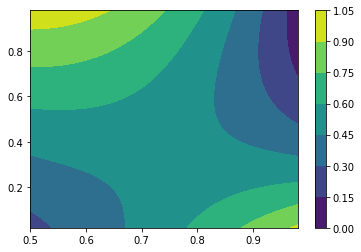

In [248]:
plt.contourf(KK,BETA,discrimMat)
plt.colorbar()

In [249]:
def get_u2_D0_u10(K,beta):
    u2 = (beta + 1)/(2*beta) - (np.sqrt(K*(K*beta**2 - 6*K*beta + K +4*beta)))/(2*K*beta)
    return(u2)
def get_leading_Jstar_eval_D0_u10(K,beta):
    hu2 = get_u2_D0_u10(K,beta)
    hr2 = 1 - beta*hu2
    hr1 = 1; hu1 = 0
    hw = 1 + K*hr2*hu2
    Jstar = Make_Jstar_np(hw,hu1,hu1,hr1,hr1,0,0,beta)
    evals = linalg.eigvals(Jstar)
    evals_mag = abs(evals)
    lead_eval = max(evals_mag)
    return(lead_eval)

u2vec = [get_u2_D0_u10(K,beta) for K,beta in zip(Kflat, betaflat)]
u2mat = np.reshape(u2vec,finalshape)
#eigvec = [get_leading_Jstar_eval_D0_u10(K,beta) for K,beta in zip(Kflat,betaflat)]
#eigmat = np.reshape(eigvec,finalshape)

In [245]:
max(get_u2_D0_u10(Kflat,betaflat))

0.9793899843052216

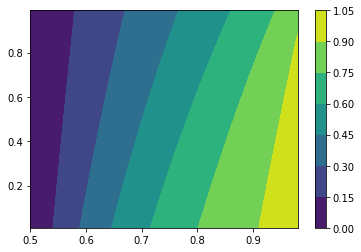

In [246]:
p = plt.contourf(KK,BETA,u2mat)
plt.colorbar(p)

# Case K = 1 D = 0

In [67]:
U1 = 1
U2 = 1

# Case #1
hu1 = 1
hu2 = 0
hr1 = 1 - beta
hr2 = 1
hw = 1 + hr1*hu1 + hr2*hu2
A1 = hw*hu1/(1+hr1)
A2 = hw*hu2/(1+hr2)
Jstar = Matrix([[U1*(1+hr1-hu1*hr1)/hw, -hu1*hr2*U2/hw, A1*(1 - hu1)/hw, -hu1*A2/hw],
                [-hu2*hr1*U1/hw, U2*(1+hr2-hu2*hr2)/hw,  - hu2*A2/hw, A2*(1-hu2)/hw],
               [-beta*hr1/(1+hr1),0,1/(1+hr1),0],
               [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]])
display(Jstar)
lamda = symbols('lamda')
charpoly = Jstar.charpoly(lamda)
charpoly = charpoly.as_expr()

solve(charpoly,lamda)

Matrix([
[               1/(2 - beta), -1/(2 - beta),            0,   0],
[                          0,  2/(2 - beta),            0,   0],
[-beta*(1 - beta)/(2 - beta),             0, 1/(2 - beta),   0],
[                          0,       -beta/2,            0, 0.5]])

[0.500000000000000, -2.0/(beta - 2.0), -1/(beta - 2.0)]

## Case 2 of K = 1, D = 0: u1 = u2 = 1/2

In [61]:
hu1 = Rational(1,2)
hu2 = Rational(1,2)
hr1 = 1 - beta*hu1
hr2 = 1 - beta*hu2
hw = 1 + hr1*hu1 + hr2*hu2
A1 = hw*hu1/(1+hr1)
A2 = hw*hu2/(1+hr2)
Jstar = Matrix([[U1*(1+hr1-hu1*hr1)/hw, -hu1*hr2*U2/hw, A1*(1 - hu1)/hw, -hu1*A2/hw],
                [-hu2*hr1*U1/hw, U2*(1+hr2-hu2*hr2)/hw,  - hu2*A2, A2*(1-hu2)/hw],
               [-beta*hr1/(1+hr1),0,1/(1+hr1),0],
               [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]]) # didn't bother using that J* specific for u1 = u2
display(Jstar)
evals = Jstar.eigenvals()
charpoly = Jstar.charpoly(lamda)
charpoly = charpoly.as_expr()
charpoly

Matrix([
[    (3/2 - beta/4)/(2 - beta/2),     (beta/4 - 1/2)/(2 - beta/2), (1 - beta/4)/(2*(2 - beta/2)**2), -(1 - beta/4)/(2*(2 - beta/2)**2)],
[    (beta/4 - 1/2)/(2 - beta/2),     (3/2 - beta/4)/(2 - beta/2),   -(1 - beta/4)/(2*(2 - beta/2)),  (1 - beta/4)/(2*(2 - beta/2)**2)],
[-beta*(1 - beta/2)/(2 - beta/2),                               0,                   1/(2 - beta/2),                                 0],
[                              0, -beta*(1 - beta/2)/(2 - beta/2),                                0,                    1/(2 - beta/2)]])

lamda**4 + lamda**3*(10 - beta)/(beta - 4) + lamda**2*(-beta**2 - 4*beta + 36)/(beta**2 - 8*beta + 16) + lamda*(beta**4 - 6*beta**3 - 20*beta**2 - 40*beta + 448)/(8*beta**3 - 96*beta**2 + 384*beta - 512) + (beta**5 - 4*beta**4 - 16*beta**2 - 16*beta + 256)/(8*beta**4 - 128*beta**3 + 768*beta**2 - 2048*beta + 2048)

In [63]:
solns = solve(charpoly,lamda)

## Case 3 of K = 1, D = 0: hbu > 0   so  $\hat{W} = 1$

In [46]:
#Case 3a: u1 = u2 = 0

hu1 = 0
hu2 = 0
U1 = 1
U2 = 1
A1 = 0
A2 = 0
hr1 = r1
hr2 = r2
Jstar = Matrix([[U1*(1+hr1-hu1*hr1), -hu1*hr2*U2, A1*(1 - hu1), -hu1*A2],
                [-hu2*hr1*U1, U2*(1+hr2-hu2*hr2),  - hu2*A2,A2*(1-hu2),],
               [-beta*hr1/(1+hr1),0,1/(1+hr1),0],
               [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]]) # didn't bother using that J* specific for u1 = u2
display(Jstar)

charpoly = Jstar.charpoly(lamda)
factor(charpoly.as_expr())

Matrix([
[                  \hat{r_1} + 1,                               0,                 0,                 0],
[                              0,                   \hat{r_2} + 1,                 0,                 0],
[-\hat{r_1}*beta/(\hat{r_1} + 1),                               0, 1/(\hat{r_1} + 1),                 0],
[                              0, -\hat{r_2}*beta/(\hat{r_2} + 1),                 0, 1/(\hat{r_2} + 1)]])

(\hat{r_1} - lamda + 1)*(\hat{r_2} - lamda + 1)*(\hat{r_1}*lamda + lamda - 1)*(\hat{r_2}*lamda + lamda - 1)/((\hat{r_1} + 1)*(\hat{r_2} + 1))

In [47]:
#Case 3c (Case 3b did by hand): r1 = r2 = 0
hw = 1
hu1 = u1
hu2 = u2
hr1 = 0
hr2 = 0

U1 = 1
U2 = 1
A1 = hw*hu1/(1+hr1)
A2 = hw*hu2/(1+hr2)

Jstar = Matrix([[U1*(1+hr1-hu1*hr1), -hu1*hr2*U2, A1*(1 - hu1), -hu1*A2],
                [-hu2*hr1*U1, U2*(1+hr2-hu2*hr2),  - hu2*A2,A2*(1-hu2),],
               [-beta*hr1/(1+hr1),0,1/(1+hr1),0],
               [0,-beta*hr2/(1+hr2),0,1/(1+hr2)]]) # didn't bother using that J* specific for u1 = u2
display(Jstar)

charpoly = Jstar.charpoly(lamda)
factor(charpoly.as_expr())

Matrix([
[1, 0, \hat{u_1}*(1 - \hat{u_1}),      -\hat{u_1}*\hat{u_2}],
[0, 1,             -\hat{u_2}**2, \hat{u_2}*(1 - \hat{u_2})],
[0, 0,                       1.0,                         0],
[0, 0,                         0,                       1.0]])

1.0*(1.0*lamda - 1.0)**4